# Récupération des trajectoires depuis un fichier de sortie symuvia et Applications

## Format des données

Les données symuvia sont au format XML. Il faut donc repérer les noeuds intéressants.
Dans `<SIMULATION>`, dans `<INSTANTS>`:

```xml
<INST nbVeh="12" val="36.00">
        <CREATIONS/>
        <TRAJS>
          <TRAJ abs="653839.68" acc="0.00" dst="505.90" id="0" ord="6836225.04" tron="T_56451886_FRef" type="VL" vit="18.00" voie="1" z="0.00"/>
          <TRAJ abs="645811.61" acc="0.00" dst="251.45" id="1" ord="6836249.71" tron="T_727978488_FRef" type="VL" vit="13.89" voie="1" z="0.00"/>
          <TRAJ abs="653981.32" acc="0.00" dst="363.80" id="2" ord="6836213.67" tron="T_56451886_FRef" type="VL" vit="18.00" voie="1" z="0.00"/>
          <TRAJ abs="639992.32" acc="0.00" dst="180.94" id="3" ord="6839115.39" tron="T_710955484_FRef" type="VL" vit="18.00" voie="1" z="0.00"/>
          <TRAJ abs="649753.31" acc="0.00" dst="51.36" id="4" ord="6836306.12" tron="T_56441739_FRef" type="VL" vit="18.00" voie="1" z="0.00"/>
          <TRAJ abs="654122.79" acc="0.00" dst="221.72" id="5" ord="6836200.62" tron="T_56451886_FRef" type="VL" vit="18.00" voie="1" z="0.00"/>
          <TRAJ abs="647988.31" acc="0.00" dst="213.10" id="6" ord="6836166.26" tron="T_56441864_FRef" type="VL" vit="18.00" voie="1" z="0.00"/>
          <TRAJ abs="645624.26" acc="0.00" dst="51.44" id="7" ord="6836286.92" tron="T_727978488_FRef" type="VL" vit="13.89" voie="1" z="0.00"/>
          <TRAJ abs="645385.26" acc="0.00" dst="100.00" id="8" ord="6836618.26" tron="T_865040266_FRef" type="VL" vit="13.89" voie="1" z="0.00"/>
          <TRAJ abs="654264.05" acc="0.00" dst="79.59" id="9" ord="6836185.10" tron="T_56451886_FRef" type="VL" vit="18.00" voie="1" z="0.00"/>
          <TRAJ abs="645673.67" acc="0.00" dst="16.98" id="10" ord="6836461.42" tron="T_865037904_FRef" type="VL" vit="8.33" voie="1" z="0.00"/>
          <TRAJ abs="648223.84" acc="0.00" dst="8.74" id="11" ord="6836084.39" tron="T_56442110_FRef" type="VL" vit="8.33" voie="1" z="0.00"/>
        </TRAJS>
    ...
```

Les trajectoires des véhicules sont discrétisées par instant `<INST>` avec les attributs `nbVeh` (nombre de véhicules), `val` (valeur temporelle de l'instant - `t` dans le tableau).
Ensuite les points des trajectoires sont stockées dans des noeuds enfants `<TRAJ>`de l'élément `<TRAJS>`. Les attributs sont les suivants :
* `id` : Identifiant du véhicule
* `abs` : Abscisse de la position du véhicule en projection *Lambert 93* (`X` dans le tableau)
* `ord` : Ordonnée de la position du véhicule en projection *Lambert 93* (`Y` dans le tableau)
* `tron` : Nom du tronçon sur lequel le véhicule circule
* `dst` : Distance sur le lien
* `vit`: Vitesse du véhicule

Passons maintenant en python. On charge la bibliothèque nécessaire à la lecture du fichier **XML** et initialise la variable contenant le chemin d'accès au fichier **XML**.

In [35]:
from lxml import etree
import pandas as pd
from matplotlib import pyplot as plt
filename = 'Init_070000_120000_traf.xml';
tree = etree.parse(filename);

## Récupération des trajectoires en projection *Lambert 93*

Ce type de trajectoire nous permettra de simuler des données GPS dans la suite. 
On choisit une approche par dataframe à l'aide du package `pandas`.
Le code python permettant cette mise en forme est le suivant :


In [32]:
# Initialisation des variables
ID = [];
ABS = [];
ORD = [];
TRON = [];
DST = [];
VIT = [];
T = [];

# Navigation dans le xml à la recherche des instansts et boucle sur les instants
for instant in tree.xpath("/OUT/SIMULATION/INSTANTS/INST"):
    #on boucle sur les trajectoires
    for point in instant.xpath("TRAJS/TRAJ"):
        ID.append(int(point.get("id")));
        T.append(float(instant.get("val")));
        ABS.append(float(point.get("abs")));
        ORD.append(float(point.get("ord")));
        TRON.append(point.get("tron"));
        VIT.append(float(point.get("vit")));
        DST.append(float(point.get("dst")));

# Création DataFrame
df = pd.DataFrame(
        {"id" : ID,
         "t": T,
         "X" : ABS,
         "Y" : ORD,
         "vit" : VIT,
         "dst" : DST,
         "tron" : TRON})

# Rearrange
df = df[["id", "t", "X", "Y", "vit","tron", "dst"]];

# Affichage des 5 premières lignes
df.head(5)

,id,t,X,Y,vit,tron,dst
0,0,8.0,654340.98,6836174.27,18.0,T_56451886_FRef,1.9
1,0,9.0,654323.16,6836176.78,18.0,T_56451886_FRef,19.9
2,0,10.0,654305.33,6836179.29,18.0,T_56451886_FRef,37.9
3,0,11.0,654287.51,6836181.80,18.0,T_56451886_FRef,55.9
4,0,12.0,654269.69,6836184.31,18.0,T_56451886_FRef,73.9


### Enregistrement dans un fichier csv

```python
df.to_csv("out.csv", sep='\t');
```
[Voir la description de la fonction](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_csv.html)

### Illustration 1 : Tracé des trajets des véhicules sur l'ensemble du réseau
Illsutrons le tracé de la trajectoire des véhicules 1, 100 et 1000 dans la projection *Lambert 93*.

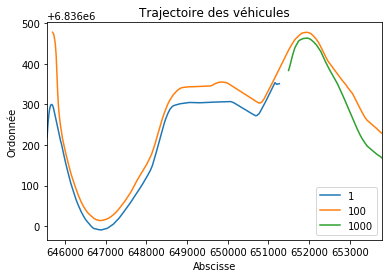

In [44]:
# On récupère le sous dataframe
filterIndexes = [1,100,1000]
subDf = df[df.id.isin(filterIndexes)].sort_values(by = ['id', 't'])

# Initialisation de la figure
ax = subDf.plot();
ax.clear()

# on trace les trajectoires
subDf.groupby(by = 'id').plot(x = 'X', y = 'Y',ax=ax, legend = False)
plt.xlabel('Abscisse')
plt.ylabel('Ordonnée')
plt.title('Trajectoire des véhicules')
plt.legend(filterIndexes)
plt.show()

[Aller à l'aide la fonction plot des dataframes](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html)

### Illustration 2 : Tracé un diagramme espace temps sur un tronçon en particulier
L'illustration suivante nous permet de tracer le diagramme espace-temps avec les trajectoires des véhicules.
Le tronçon choisit arbitrairemet est *T_56451886_FRef*.
Pour des raisons de calculs et de visibilié, on ne tracera que les 50 premières trajectoires.

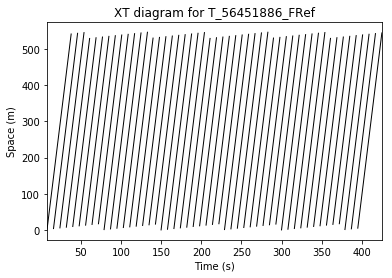

In [66]:
# On récupère le sous dataframe filtré par rapport au tronçon
subDf = df [df.tron=="T_56451886_FRef"]
subDf = subDf[subDf.id.isin(pd.unique(subDf.id)[0:50])].sort_values(by = ['id', 't'])

# Initialisation de la figure
ax = subDf.plot()
ax.clear()

# On trace les trajectoires
subDf2.groupby(by = 'id').plot(x = 't', y = 'dst', ax=ax, legend=False, color = 'black', linewidth = 1)
plt.xlabel('Time (s)')
plt.ylabel('Space (m)')
plt.title('XT diagram for ' + "T_56451886_FRef")
plt.show()

### Illustration 3 : Tracé de la chronique de vitesse pour un véhicule en particulier
Ici, on va tracer la chronique de vitesse du véhicule numéro 10 sur l'ensemble de son trajet.

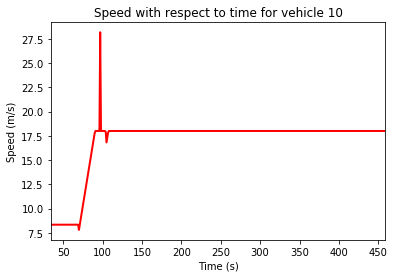

In [74]:
# On trace la chronique de vitesse du véhicule 10
df[df['id']==10].sort_values(by = 't').plot(x = 't', y = 'vit', legend = False, color = 'red', linewidth = 2)
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')
plt.title('Speed with respect to time for vehicle 10')
plt.show()